# **Exercise 1: MD simulations of LJ-Ag**

## *SVOLGIMENTO PUNTO 1*

---

## Consegna

### Parametri

In all simulations model Ag interatomic interactions using the LJ potential ($\varepsilon = 0.345$ eV and $\sigma = 2.644$ Å) with the cutoff radius at $R_C = 4.5$ Å. Assume $t_\text{th} = 3$ ps as thermalization time and use the simulation cell of 256-atoms (file `fcc100a256.txt` on the elearning page) unless stated differently. From point 3,

### Punto 1 🛠️

Use a **sharp-cutoff** (no polynomial junction) approach and find the optimal timestep to perform a simulation from an initial temperature $T_\text{ini} = 50$ K. The optimal timestep is the maximum one such that $\frac{\delta E}{E} < 10^{−5}$. Consider the range 1, 25 fs and perform 5000 integration steps for each trial. Repeat the analysis for $T_\text{ini} = 500$ K and show that the criterion cannot be fulfilled however reducing the timestep.

### Punto 2 🔜

Implement a **7-degree polynomial** junction for $R_P < r < R_C$ with $R_P = 4.2$ Å. Use the coefficients $A, B, \dots, H$ for the 0th, 1st, ..., 7th degree term respectively, as provided in the file `poly7.py` on the elearning page. Adapt the definition of forces accordingly. Check that for $T_\text{ini} = 50$ K the simulation is consistent with the sharp-cutoff one and find the optimal timestep for $T_\text{ini} = 500$ K, $1000$ K and $2000$ K.

### Punto 3 🔜

For the following points, implement a steepest-descent procedure to start the simulation from a minimum energy configuration (use C= 0.005 Å/𝑒𝑉 and stop when the maximum force falls below 0.001 𝑒𝑉/Å).


Using the optimal timesteps found in point 2, perform 10 𝑝𝑠 long simulations for $T_\text{ini} = 500$ K, $1000$ K and $2000$ K. Plot $\langle T \rangle$ as a function of $T_\text{ini}$ , check if the condition $\langle T \rangle = \frac{T_\text{ini}}{2}$ is
fulfilled and explain the result. Visualize the atomic trajectories of the atoms at the center of the
cluster and at the cube vertices for both the lowest and highest temperature and comment on
their difference.

### Punto 4 🔜

Consider an infinite crystal slab (𝐿𝑥 = 𝐿𝑦 = 16.6416 Å) with free-surfaces in the 𝑧 direction. Add one adatom at the center of the upper surface, with 𝑧 coordinate set 2.4 Å above the maximum 𝑧 coordinate of the atoms in the cell. Perform a 300 𝑝𝑠 long simulation starting from the minimized configuration. Set 𝑇𝑖𝑛𝑖 such to achieve an equilibrium temperature 𝑇 = 850 ± 30 𝐾 and use an appropriate timestep. Trace the trajectory of the adatom over time.

### Punto 5 🔜

Repeat the analysis of point 4 using a (111)-oriented cell from the file fcc111a336+1.txt on the elearning page with 𝐿𝑥 = 𝐿𝑦 = 20.3817 Å and compare the results for the two orientations. Is the adatom diffusion likely to happen at room temperature on one or both surfaces on the same time interval?

---

## Svolgimento PUNTO 1

### 0) Importazioni e dati

In [1]:
import numpy as np
from CMS.MolecularDynamics.CrystalDynamics import CrystalDynamics as Dynamics
from CMS.MolecularDynamics.CrystalStructure import CrystalStructure as Crystal

In [2]:
# Nome del file (numero di atomi da studiare: 256)
filename = '../../../data/pos-fcc100-random/fcc100a256.txt'

#### Dati globali

In [3]:
# massa atomica dell'atomo considerato (argento)
silver_mass = 108

# range 1-25 fs per il time step
#time_steps = np.arange(1e-15, 25e-15, 1e-15)
time_steps = {
    50:  np.arange(1e-15, 25e-15, 1e-15),
    500: np.arange(0.1e-15, 10e-15, 0.5e-15)
}
# 5000 step per la simulazione a 50K, 50mila per quella a 500K
n_steps = {
    50: 5000,
    500: 50_000
}

# tempo di termalizzazione (ogni valore precedente va buttato)
t_th = 3e-12

### 1) Simulazioni 

#### 1.1) Dati

In [4]:
# temperature iniziali T_ini = 50 K e T_ini = 500 K
T_ini_punto_1 = [50, 500]

#### 1.2) Simulazione

In [5]:
# Raccolgo le energie medie e le dev std
E_tot_means = {}
E_tot_stds = {}

E_tot_list = {}
E_k_list = {}
T_list = {}

for T in T_ini_punto_1: # due temperature iniziali richieste: 50 e 500 K
    print(f"🚀 Avvio simulazione con temperatura iniziale T = {T} K, n_steps = {n_steps[T]}")
    
    E_tot_means[T] = []
    E_tot_stds[T] = []
    
    E_tot_list[T] = []
    E_k_list[T] = []
    T_list[T] = []
    
    print(f"dt =", end=' ')
    for dt in time_steps[T]: # venticinque time step diversi
        # Ogni volta inizializzo da capo il cristallo
        cristallo = Crystal.from_file(filename)
        # setto il raggio di cutoff, non la giunzione polinomiale (R_P = np.inf di default)
        cristallo.set_R_C(4.5) 
        # aggiungo la verlet cage per velocizzare
        cristallo.set_R_V(5)
    
        print(f"{dt:.1e} s,", end=' ')
        simulazione = Dynamics(cristallo, atomic_mass=silver_mass, dt=dt, temp_ini=T)
        simulazione.set_seed(12316543)
        result = simulazione.run_dynamics(n_steps=n_steps[T], 
                                          t_th=t_th,
        )
        
        # Accesso ai campi dell'oggetto result
        E_tot_means[T].append(result.mean_E_tot)
        E_tot_stds[T].append(result.std_E_tot)
        
        E_tot_list[T].append(result.energies['total'])
        E_k_list[T].append(result.energies['kinetic'])
        T_list[T].append(result.temperatures)
    print("\n")

🚀 Avvio simulazione con temperatura iniziale T = 50 K, n_steps = 5000
dt = 1.0e-15 s, 2.0e-15 s, 3.0e-15 s, 4.0e-15 s, 5.0e-15 s, 6.0e-15 s, 7.0e-15 s, 8.0e-15 s, 9.0e-15 s, 1.0e-14 s, 1.1e-14 s, 1.2e-14 s, 1.3e-14 s, 1.4e-14 s, 1.5e-14 s, 1.6e-14 s, 1.7e-14 s, 1.8e-14 s, 1.9e-14 s, 2.0e-14 s, 2.1e-14 s, 2.2e-14 s, 2.3e-14 s, 2.4e-14 s, 

🚀 Avvio simulazione con temperatura iniziale T = 500 K, n_steps = 50000
dt = 1.0e-16 s, 6.0e-16 s, 1.1e-15 s, 1.6e-15 s, 2.1e-15 s, 2.6e-15 s, 3.1e-15 s, 3.6e-15 s, 4.1e-15 s, 4.6e-15 s, 5.1e-15 s, 5.6e-15 s, 6.1e-15 s, 6.6e-15 s, 7.1e-15 s, 7.6e-15 s, 8.1e-15 s, 8.6e-15 s, 9.1e-15 s, 9.6e-15 s, 



#### 1.3) Analisi e plot

Grafico $\delta E/\langle E\rangle$ vs dt

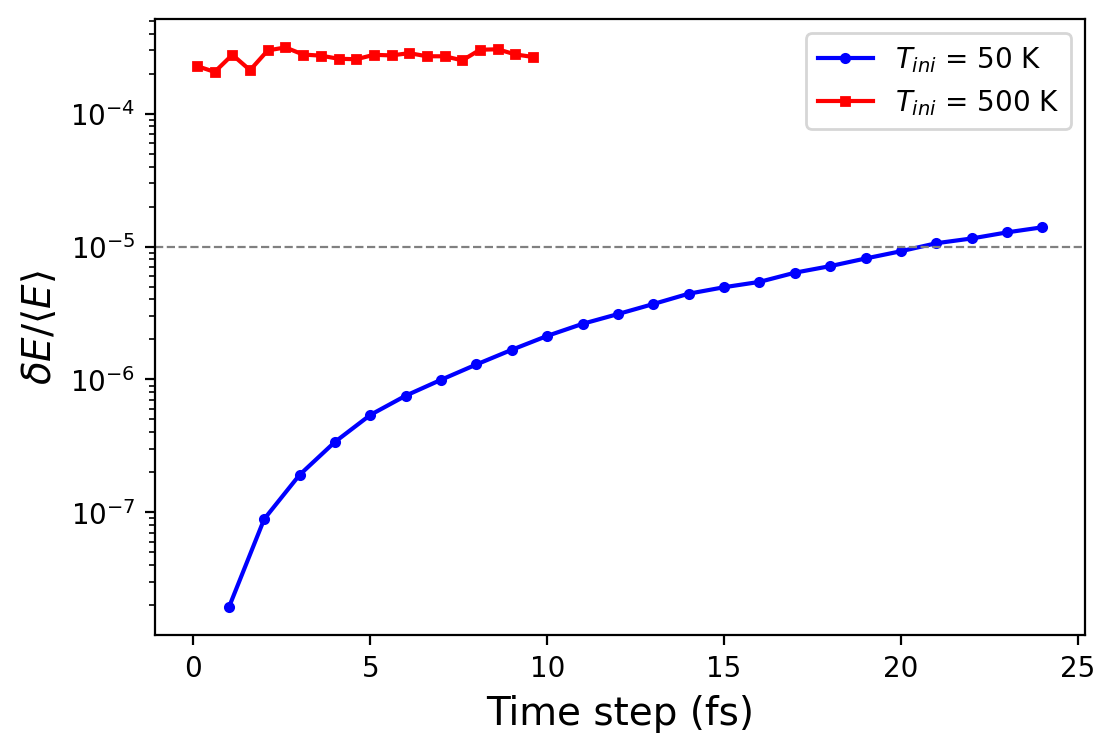

In [6]:
import matplotlib.pyplot as plt

rapporti = {}
colors = ['blue', 'red']
markers = ['o', 's']

plt.figure(figsize=(6,4), dpi=200)

for i, T in enumerate(T_ini_punto_1):
    rapporto = np.array(E_tot_stds[T])/np.abs(np.array(E_tot_means[T]))
    rapporti[T] = rapporto
    plt.plot(time_steps[T]*1e15, rapporto, color=colors[i], label=rf'$T_{{ini}}$ = {T} K', marker=markers[i], markersize=3)
    
plt.axhline(y=1e-5, color='gray', linewidth=0.8, linestyle='--')
plt.xlabel('Time step (fs)', fontsize=14)
plt.ylabel(r'$\delta E/\langle E \rangle$', fontsize=14)
plt.yscale('log')
plt.legend()
plt.show()

In [7]:
# prendo l'ultimo rapporto minore di 1e-5 per ogni temperatura
for T in T_ini_punto_1:
    indice_ultimo = 0
    trovato = False
    
    rapporto = rapporti[T]
    for i, val in enumerate(rapporto):
        if val < 1e-5:
            indice_ultimo = i
            trovato = True
            
    if trovato:
        print(f"\nPer T_ini = {T} K, l'ultimo rapporto < 1e-5 è a dt = {time_steps[T][indice_ultimo]*1e15} fs con rapporto = {rapporto[indice_ultimo]}")
    else:   
        print(f"\nPer T_ini = {T} K, non esiste un rapporto < 1e-5 nei time step considerati.")


Per T_ini = 50 K, l'ultimo rapporto < 1e-5 è a dt = 20.000000000000004 fs con rapporto = 9.22035100155943e-06

Per T_ini = 500 K, non esiste un rapporto < 1e-5 nei time step considerati.


Non si scende sotto il valore di tolleranza partendo da 500K! Si rimane all'incirca attorno a $2-3\cdot10^{-4}$. $\langle E \rangle \simeq -436$ a tutti i $dt$ (ovviamente, non cambia la fisica) $\delta E\simeq0.1$

In [8]:
E_tot_stds[500]

[np.float64(0.09941813149340835),
 np.float64(0.08989431716744717),
 np.float64(0.12094650946212933),
 np.float64(0.09268569757299326),
 np.float64(0.1305054995154042),
 np.float64(0.13734085697612192),
 np.float64(0.12142445179381514),
 np.float64(0.11918727667430974),
 np.float64(0.11290658351096047),
 np.float64(0.1119602801039643),
 np.float64(0.12084904511811573),
 np.float64(0.11965025325766596),
 np.float64(0.12435668656973707),
 np.float64(0.11790659778379216),
 np.float64(0.11779825450804998),
 np.float64(0.10976925811876605),
 np.float64(0.13192332792756872),
 np.float64(0.13296974109541018),
 np.float64(0.12162664461709746),
 np.float64(0.11639527583432654)]

In [9]:
E_tot_means[500]

[np.float64(-436.624427661424),
 np.float64(-436.6619451667755),
 np.float64(-436.6861770389958),
 np.float64(-436.6557160604861),
 np.float64(-436.66174893337876),
 np.float64(-436.6458398702158),
 np.float64(-436.6645846250116),
 np.float64(-436.6459511138221),
 np.float64(-436.65006278302036),
 np.float64(-436.64779100577573),
 np.float64(-436.6258278906205),
 np.float64(-436.5556774750831),
 np.float64(-436.56432127262747),
 np.float64(-436.6016847367307),
 np.float64(-436.54437241856886),
 np.float64(-436.55076532580483),
 np.float64(-436.44024931954044),
 np.float64(-436.4116826485578),
 np.float64(-436.4444226261976),
 np.float64(-436.4739173322319)]